# Ray Trading Example 2

In [1]:
# Imports

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import pprint
import ray
from ray.rllib.agents.ppo import PPOTrainer

from ray_trading_env import RayTradingEnvironment

INFO:ray_trading_env:ray_trading_env logger started.


In [3]:
# Start a new instance of Ray
# Note: execute cell only once!
# instance can be stopped with ray.shutdown()
ray.init()

2022-06-27 17:38:25,295	WARNING services.py:2002 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67096576 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


RayContext(dashboard_url='', python_version='3.8.8', ray_version='1.13.0', ray_commit='e4ce38d001dbbe09cd21c497fedd03d692b2be3e', address_info={'node_ip_address': '10.1.150.226', 'raylet_ip_address': '10.1.150.226', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-06-27_17-38-24_690480_52191/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-06-27_17-38-24_690480_52191/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-06-27_17-38-24_690480_52191', 'metrics_export_port': 52861, 'gcs_address': '10.1.150.226:64048', 'address': '10.1.150.226:64048', 'node_id': 'bc6d3dd929e0c655cf174fa0fdec029f38b96b18bec43345526e25a0'})

### Instantiate and Train PPOTrainer

In [4]:
# config dict for Rllib
config = {
    "env": RayTradingEnvironment,
    "env_config": {
        "config": {
            "trading_days": 252,
            "trading_cost_bps": 1e-3,
            "time_cost_bps": 1e-4,
            "ticker": "AAPL",
            # note: need to specify path when using Tune
            "data_path": "/home/jovyan/machine-learning-for-trading/AAPL_prices.csv",
            #"max_episode_steps": 252,
        },
    },

    "create_env_on_driver": True,
    # horizon needs to be specified if the env has no 
    # max_number_of_steps-like parameter
    "horizon" : 252,
}

In [5]:
# Instantiate the Trainer object using above config.
rllib_trainer = PPOTrainer(config=config)

2022-06-27 17:38:36,684	INFO trainer.py:2332 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2022-06-27 17:38:36,685	INFO ppo.py:414 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-06-27 17:38:36,685	INFO trainer.py:903 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
INFO:ray_trading_env:got data for AAPL...
/opt/conda/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
2022-06-27 17:38:36,759	WARNING env.py:135 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your conf

In [6]:
# stop trainer instance
# rllib_trainer.stop()

### Run some training loops

In [7]:
# dict with all configuration parameters
trainer_config = rllib_trainer.get_config()

In [46]:
# Train Method under the hood:
# - It runs through parallel environments (depending on the setup)
# - Collects data into a train batch (default: 4000 steps), Note: a single step in the env is two agent steps
# - Then, it passes the batch into the main train processor and it will calculate losses, do the NN update
# - This is called one single training iteration 
# - returns a dict with a lot of useful information

In [47]:
# train the trainer instance
results_list = []
for _ in range(100):
    # print dots to keep track of training
    print('.', end="")
    results = rllib_trainer.train()
    #print(f"Iteration={rllib_trainer.iteration}: R(\"return\")={results['episode_reward_mean']}")
    episode_mean_reward = results['episode_reward_mean']
    episode = rllib_trainer.iteration
    results_list.append(np.array([episode, episode_mean_reward]))
    
result_array = np.array(results_list)

....................................................................................................

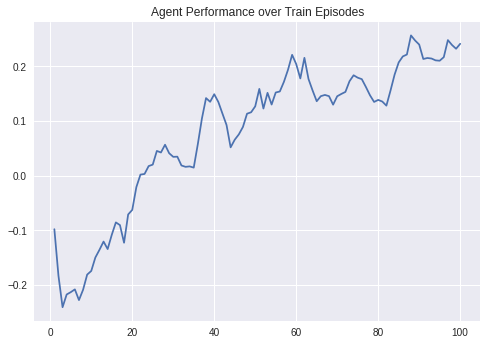

In [48]:
x = result_array[:,0]
y = result_array[:,1]
plt.plot(x,y)
plt.title("Agent Performance over Train Episodes")
plt.show()

### Some trainer functions

In [ ]:
# show weights of the current model
rllib_trainer.get_weights()

In [50]:
policy = rllib_trainer.get_policy()
policy

PPOTFPolicy

In [53]:
model = policy.model
model

In [54]:
policy.observation_space

Box(returns    -0.518692
ret_2     -13.186786
ret_5      -9.157841
ret_10     -6.979122
ret_21     -5.289787
rsi        -1.529044
macd       -5.407722
atr        -0.615589
stoch      -2.762308
ultosc     -3.964109
dtype: float32, returns     0.332152
ret_2      11.431712
ret_5      10.235379
ret_10      9.135829
ret_21      8.238228
rsi         1.499695
macd        5.705033
atr         5.415272
stoch       2.712635
ultosc      2.763141
dtype: float32, (10,), float32)

In [56]:
obs = np.array([policy.observation_space.sample()])
obs

array([[-0.32040977, -7.680346  , -6.1790137 ,  3.937136  , -3.794715  ,
        -0.6995235 ,  0.81988394, -0.4039787 ,  1.3300564 , -0.20448495]],
      dtype=float32)

In [72]:
from ray.rllib.utils.numpy import softmax
# Get the action logits (as tf tensor).
logits, _ = model({"obs": obs})
# Numpyize the tensor by running `logits` through the Policy's own tf.Session.
logits_np = policy.get_session().run(logits)
# Convert logits into action probabilities and remove the B=1.
action_probs = np.squeeze(softmax(logits_np))

In [76]:
# Sample an action, using the probabilities.
action = np.random.choice([0, 1, 2], p=action_probs)
action

0

In [77]:
policy.action_space

Discrete(3)

In [78]:
action = policy.action_space.sample()
action

2

In [ ]:
# rllib_trainer.step()

In [63]:
rllib_trainer.evaluation_metrics

{'evaluation': {'episode_reward_max': nan,
  'episode_reward_min': nan,
  'episode_reward_mean': nan}}

In [ ]:
rllib_trainer.get_state()

In [89]:
rllib_trainer.evaluate()

{'evaluation': {'episode_reward_max': 1.198757276091062,
  'episode_reward_min': -0.4484348432315458,
  'episode_reward_mean': 0.437726364666634,
  'episode_len_mean': 252.0,
  'episode_media': {},
  'episodes_this_iter': 7,
  'policy_reward_min': {},
  'policy_reward_max': {},
  'policy_reward_mean': {},
  'custom_metrics': {},
  'hist_stats': {'episode_reward': [0.187161018604307,
    -0.4484348432315458,
    1.0505278125206798,
    0.41999610501018625,
    1.198757276091062,
    0.34090612006800347,
    0.31517106360374547],
   'episode_lengths': [252, 252, 252, 252, 252, 252, 252]},
  'sampler_perf': {'mean_raw_obs_processing_ms': 0.08006753592655579,
   'mean_inference_ms': 1.0814950324367845,
   'mean_action_processing_ms': 0.05050279806995916,
   'mean_env_wait_ms': 0.18681591001526823,
   'mean_env_render_ms': 0.0},
  'off_policy_estimator': {},
  'timesteps_this_iter': 2000}}

### Saving and Restoring A Trainer Instance

In [79]:
# create a checkpoint with trainer.save()
checkpoint_file = rllib_trainer.save()
print(f"Trainer (at iteration {rllib_trainer.iteration} was saved in '{checkpoint_file}'!")

Trainer (at iteration 100 was saved in '/home/jovyan/ray_results/PPOTrainer_RayTradingEnvironment_2022-06-27_15-55-12dxqfl4ph/checkpoint_000100/checkpoint-100'!


In [84]:
# checkpoint dir
print("checkpoint files:")
os.listdir(os.path.dirname(checkpoint_file))

checkpoint files:


['.is_checkpoint', 'checkpoint-100.tune_metadata', 'checkpoint-100']

In [85]:
new_trainer = PPOTrainer(config=config)

INFO:ray_trading_env:got data for AAPL...
INFO:ray_trading_env:None
/opt/conda/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
2022-06-27 16:17:35,623	WARNING env.py:135 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9367 entries, (Timestamp('1981-01-30 00:00:00'), 'AAPL') to (Timestamp('2018-03-27 00:00:00'), 'AAPL')
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   returns  9367 non-null   float64
 1   ret_2    9367 non-null   float64
 2   ret_5    9367 non-null   float64
 3   ret_10   9367 non-null   float64
 4   ret_21   9367 non-null   float64
 5   rsi      9367 non-null   float64
 6   macd     9367 non-null   float64
 7   atr      9367 non-null   float64
 8   stoch    9367 non-null   float64
 9   ultosc   9367 non-null   float64
dtypes: float64(10)
memory usage: 1.1+ MB


2022-06-27 16:17:36,094	WARNING util.py:65 -- Install gputil for GPU system monitoring.
(RolloutWorker pid=36337) INFO:ray_trading_env:ray_trading_env logger started.
(RolloutWorker pid=36336) INFO:ray_trading_env:ray_trading_env logger started.
(RolloutWorker pid=36336) INFO:ray_trading_env:got data for AAPL...
(RolloutWorker pid=36336) /opt/conda/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=36336)   logger.warn(
(RolloutWorker pid=36336) 2022-06-27 16:17:37,943	WARNING env.py:135 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=36337) INFO:ray_trading_env:got data for AAPL...
(RolloutWorker pid=36337) /opt/conda/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN

In [86]:
# new trainer instacne performs very poorly
results = new_trainer.evaluate()
print(f"Evaluating new trainer: R={results['evaluation']['episode_reward_mean']}")

Evaluating new trainer: R=-0.3757544692309273


In [87]:
# restore the trained weights of the first trainer
print(f"Before restoring: Trainer is at iteration={new_trainer.iteration}")
new_trainer.restore(checkpoint_file)
print(f"After restoring: Trainer is at iteration={new_trainer.iteration}")

2022-06-27 16:18:59,636	INFO trainable.py:588 -- Restored on 10.1.150.226 from checkpoint: /home/jovyan/ray_results/PPOTrainer_RayTradingEnvironment_2022-06-27_15-55-12dxqfl4ph/checkpoint_000100/checkpoint-100
2022-06-27 16:18:59,637	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 387.05677485466003, '_episodes_total': 1586}


Before restoring: Trainer is at iteration=0
After restoring: Trainer is at iteration=100


In [88]:
# performs already much better
results = new_trainer.evaluate()
print(f"Evaluating restored trainer: R={results['evaluation']['episode_reward_mean']}")

Evaluating restored trainer: R=0.16071565570886112


### Test larger number of workers

In [17]:
# stop the old trainer instance
rllib_trainer.stop()

In [18]:
# set "num_workers" : 2
config = {
    "env": RayTradingEnvironment,
    "create_env_on_driver": True,
    # horizon needs to be specified if the env has no 
    # max_number_of_steps-like parameter
    "horizon" : 252,
    "num_workers" : 2
}

In [ ]:
rllib_trainer = PPOTrainer(config=config)

In [24]:
# number of workers of the config
rllib_trainer.get_config().get('num_workers')

4

In [27]:
%%time
results_list = []
for _ in range(10):
    # print dots to keep track of training
    print('.', end="")
    results = rllib_trainer.train()
    #print(f"Iteration={rllib_trainer.iteration}: R(\"return\")={results['episode_reward_mean']}")
    episode_mean_reward = results['episode_reward_mean']
    episode = rllib_trainer.iteration
    results_list.append(np.array([episode, episode_mean_reward]))
    
result_array = np.array(results_list)

..........CPU times: user 39.8 s, sys: 4.57 s, total: 44.4 s
Wall time: 33.1 s


In [ ]:
# stop the old trainer instance
rllib_trainer.stop()

In [30]:
# set "num_workers" : 16
config = {
    "env": RayTradingEnvironment,
    "create_env_on_driver": True,
    # horizon needs to be specified if the env has no 
    # max_number_of_steps-like parameter
    "horizon" : 252,
    "num_workers" : 16
}

In [ ]:
rllib_trainer = PPOTrainer(config=config)

In [33]:
rllib_trainer.get_config().get('num_workers')

16

In [34]:
%%time
results_list = []
for _ in range(10):
    # print dots to keep track of training
    print('.', end="")
    results = rllib_trainer.train()
    #print(f"Iteration={rllib_trainer.iteration}: R(\"return\")={results['episode_reward_mean']}")
    episode_mean_reward = results['episode_reward_mean']
    episode = rllib_trainer.iteration
    results_list.append(np.array([episode, episode_mean_reward]))
    
result_array = np.array(results_list)

..........CPU times: user 38.2 s, sys: 3.56 s, total: 41.8 s
Wall time: 27.8 s


### Close Session

In [90]:
rllib_trainer.stop()
new_trainer.stop()

In [91]:
ray.shutdown()